In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jul 16 00:24:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip3 install tensorflow-text
!pip3 install tf-models-official
!pip3 install imbalanced-learn
!pip3 install scikit-learn==0.21
!pip3 install pandas==0.24.2

     |████████████████████████████████| 4.3MB 3.7MB/s 
     |████████████████████████████████| 1.6MB 3.8MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 645kB 11.8MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 102kB 7.2MB/s 
     |████████████████████████████████| 1.2MB 13.1MB/s 
     |████████████████████████████████| 215kB 20.0MB/s 
     |████████████████████████████████| 37.2MB 1.3MB/s 
     |████████████████████████████████| 358kB 35.4MB/s 
     |████████████████████████████████| 686kB 33.7MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=45ee57eca305cc2232220778a0d8836aee9749e59021e0573822e2a676a93156
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-cp37-none-any.whl size=22258 sha256=95affaa73298f20f7ab0f30511dca2390ab55

In [1]:
import os,re,sys,time
import math,random
import subprocess,shlex
import unicodedata,pickle
import scipy.io as sio
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
from datetime import datetime
def generate_time_stamp():
  dateTimeObj = datetime.now()
  timestampStr = dateTimeObj.strftime("%Y%b%d_%H_%M")
  return timestampStr

In [3]:
data_location = 'drive/MyDrive/Instagram/8emtion+cyberaggression.csv'

In [4]:
def load_data(data_location):
    df = pd.read_csv(data_location)
    # filter data:
    df = df[df['label']!='aggression']
    df = df[df['label']!='notAggression']
    labels = list(df['label'].unique())
    # print(df.describe())
    df = df[['data','label']]
    for label in labels:
        df['label'] = df['label'].replace(label, labels.index(label))

    print(df['label'].describe())
    return labels,df
  

labels,loaded_data = load_data(data_location)
print(labels)

count    51332.000000
mean         2.867743
std          1.967282
min          0.000000
25%          2.000000
50%          2.000000
75%          4.000000
max          7.000000
Name: label, dtype: float64
['anger', 'fear', 'joy', 'sadness', 'surprise', 'anticipation', 'trust', 'disgust']


In [5]:
oversample = RandomOverSampler(sampling_strategy='not majority')
# fit and apply the transform
df = loaded_data
df = df.dropna()
X,y = [[i] for i in df.data], df.label
X_over, y_over = oversample.fit_resample(X, y)

---

In [6]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 22.3MB 1.7MB/s 


In [7]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

In [8]:
bert_model_name = 'albert_en_base' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

BERT model selected           : https://tfhub.dev/tensorflow/albert_en_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/albert_en_preprocess/3


In [9]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [   2   48   25  145   40 5289 1308  187    3    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]
Loaded BERT: https://tfhub.dev/tensorflow/albert_en_base/2
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.5642032  -0.5833844   0.8920308  -0.8834061  -0.59008014 -0.9748928
  0.5973393  -0.56507766  0.6582631  -0.9999051   0.9224697   0.57890934]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.9379131   0.28508675 -0.37701288 ...  0.19408287 -1.1221759
   0.5021096 ]
 [ 1.6732266  -1.2593422   0.98551506 ... -0.03488834  2.440245
  -1.4151821 ]
 [ 1.5726159  -0.7276668  -0.6132502  ...  1.1369401  -0.24407126
  -0.20238848]
 ...
 [ 0.46375072  0.78065157 -0.00772653 ...  0.3692444   0.99164057
  -1.1032673 ]
 [ 0.44642863  0.85889894  0.02044386 ...  0.40769553  1.0863212
  -1.0217941 ]
 [ 0.46782395  0.88188314  0.02625205

In [10]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(100, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.5)(net)
  net = tf.keras.layers.Dense(10, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [11]:
classifier_model = build_classifier_model()

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_over, y_over = shuffle(X_over, y_over, random_state=0)
print(len(X_over))
limit = len(X_over)//32*32
print(limit)
X_train, X_test, y_train, y_test = train_test_split(X_over[:limit], y_over[:limit], test_size=0.25, random_state=42)

115984
115968


In [13]:
epochs = 20
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
# steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
steps_per_epoch = len(X_test)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)


init_lr = 2e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

stamp = generate_time_stamp()
checkpoint_path = f"drive/MyDrive/Instagram/saved/{stamp}/cp-{epochs:04d}.ckpt"
print(checkpoint_path)
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=1*batch_size)


classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(X_train, y_train,
                               validation_data=(X_test, y_test),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=[cp_callback])

classifier_model.save(checkpoint_path)

drive/MyDrive/Instagram/saved/2021Jul16_00_26/cp-0020.ckpt
Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Epoch 1/20
  32/2718 [..............................] - ETA: 28:32 - loss: 2.7953 - sparse_categorical_accuracy: 0.1182
Epoch 00001: saving model to drive/MyDrive/Instagram/saved/2021Jul16_00_26/cp-0020.ckpt
  64/2718 [..............................] - ETA: 29:00 - loss: 2.8197 - sparse_categorical_accuracy: 0.1025
Epoch 00001: saving model to drive/MyDrive/Instagram/saved/2021Jul16_00_26/cp-0020.ckpt
  96/2718 [>.............................] - ETA: 28:57 - loss: 2.8111 - sparse_categorical_accuracy: 0.1068
Epoch 00001: saving model to drive/MyDrive/Instagram/saved/2021Jul16_00_26/cp-0020.ckpt
 128/2718 [>.............................] - ETA: 28:35 - loss: 2.8162 - sparse_categorical_accuracy: 0.1042
Epoch 00001: saving model to drive/MyDrive/Instagram/saved/2021Jul16_00_26/cp-0020.ckpt
 160/2718 [>.............................] - ETA: 28:16 - loss: 2.8172 - spa

In [14]:
loss, accuracy = classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

906/906 [==============================] - 206s 228ms/step - loss: 0.7878 - sparse_categorical_accuracy: 0.7412
Loss: 0.787839412689209
Accuracy: 0.7412389516830444


In [ ]:
history_dict = history.history
print(history_dict.keys())

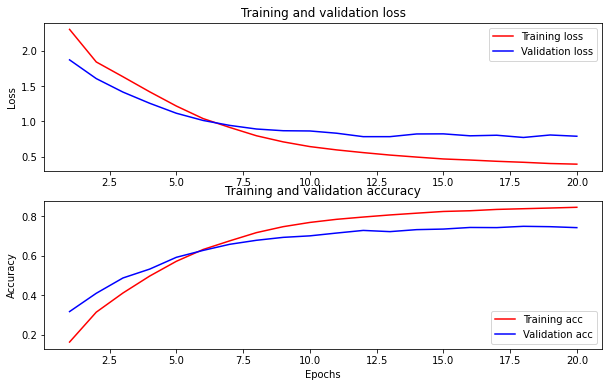

In [21]:
acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [22]:
test_file_path = 'drive/MyDrive/Instagram/Instagram4_with_label_cleaned.csv'
def load_test_data(test_file_path):
    df = pd.read_csv(test_file_path)
    test_data = [[i] for i in df.text]
    print(test_data[:3])
    return test_data

test_data = load_test_data(test_file_path)

[['Till date  has been a great inspiration to me and my family. For a start I deposited $800 and after a week I got $7,800 return. Her accuracy and reliability can’t be compromised'], [' when you give up on snowboarding you should get a mountain bike.'], ['Ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha love it']]


In [23]:
results = classifier_model.predict(test_data)

In [24]:
results_argmax = tf.argmax(results, axis=1)
results

array([[-4.12238866e-01, -8.88683498e-01,  2.27733350e+00, ...,
        -1.14966285e+00, -5.34203625e+00, -5.33546734e+00],
       [ 6.00646257e+00, -3.65174007e+00, -6.19593382e-01, ...,
         4.20891809e+00, -6.70039463e+00, -6.71377945e+00],
       [-4.67684793e+00,  2.08486050e-01,  1.03419155e-01, ...,
        -4.62732601e+00, -9.08507252e+00, -9.73841953e+00],
       ...,
       [-2.42462516e+00, -1.09267926e+00,  1.97379601e+00, ...,
        -1.39361250e+00, -7.98872614e+00, -7.94919157e+00],
       [ 1.47144258e+00, -1.61866045e+00,  2.14359450e+00, ...,
         1.18234479e+00, -5.25993776e+00, -4.32130623e+00],
       [-3.02853537e+00,  4.09134477e-03,  2.40331817e+00, ...,
        -2.51685476e+00, -5.79732990e+00, -6.14883041e+00]], dtype=float32)

In [29]:
with open('drive/MyDrive/Instagram/output.txt', 'w') as fout:
  for i,j in zip(results_argmax, test_data):
    # fout.write(f'{i},{j.numpy()[0]}\n')
    fout.write(f'{i},{labels[i]},{j[0].replace(", ",",").replace(","," ")}\n')

In [28]:
classifier_model.save_weights('drive/MyDrive/Instagram/saved/20_epoch_model_weights')